In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nnacc
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
data_dir = './demo_data/'

mask = np.loadtxt(data_dir + 'mask_gamma.txt')[:,1].astype(bool)

inv_cov = np.load(data_dir + 'invcov_gamma.npy')[:,mask][mask,:]
cov = np.linalg.inv(inv_cov)
sigma = np.sqrt(np.diag(cov))
cov /= sigma[None,:] * sigma[:,None]
inv_cov = torch.tensor(np.linalg.inv(cov), dtype=torch.float)

obs_datavector = torch.tensor(np.loadtxt(data_dir + 'combined.txt')[mask,1] / sigma, dtype=torch.float)

priors = []

f = open(data_dir + 'prior.txt', 'r')
for line in f:
    param = line.split()
    priors.append({
        'param': param[0],
        'dist': param[1],
        'arg1': float(param[2]),
        'arg2': float(param[3])
    })
f.close()

In [3]:
class X_transform(nn.Module):
    def __init__(self, X_mean=None, X_std=None):
        super(X_transform, self).__init__()
        
        self.X_mean = nn.Parameter(X_mean)
        self.X_std = nn.Parameter(X_std)
        
    def forward(self, X):
        return (X - self.X_mean[None,:]) / self.X_std[None,:]

class y_transform(nn.Module):
    def __init__(self, y_mean=None, y_std=None):
        super(y_transform, self).__init__()
        
        self.y_mean = nn.Parameter(y_mean)
        self.y_std = nn.Parameter(y_std)
        
    def forward(self, y):
        return y * self.y_std[None,:] + self.y_mean[None,:]

xtransf = X_transform(torch.zeros(len(priors)), torch.zeros(len(priors)))
ytransf = y_transform(torch.zeros(mask.sum()), torch.zeros(mask.sum()))
model = nnacc.Predictor(len(priors), mask.sum(), X_transform=xtransf, y_transform=ytransf)

model.load_state_dict(torch.load(data_dir + 'model.pt'))

<All keys matched successfully>

Note that bounded parameters need to be transformed to unbounded ones to avoid numerical issues with HMC at the bounds. To do this, we reparameterize the uniform priors as Gaussians and then transform them back to uniform when needed. In this demo, for simplicity of the prior expression, all parameters are reparameterized as standard normal distributions and transformed to the appropriate distribution.

In [4]:
def gauss2unif(x):
    return 0.5 * (1 + torch.erf(x / np.sqrt(2)))

def transform(x):
    transformed_x = []
    
    for i, p in enumerate(priors):
        if p['dist'] == 'gauss':
            transformed_x.append(x[i] * p['arg2'] + p['arg1'])
        else:
            transformed_x.append(gauss2unif(x[i]) * (p['arg2'] - p['arg1']) + p['arg1'])
    
    return torch.stack(transformed_x)

In [5]:
def prior(x):
    return -0.5 * torch.sum(x.square())

def likelihood(x):
    pred_datavector = model(transform(x))
    
    delta = pred_datavector - obs_datavector
    
    return -0.5 * (delta @ inv_cov @ delta)

def posterior(x):
    return prior(x) + likelihood(x)

In [6]:
x0 = transform(torch.randn(len(priors)) * 0.1)

sampler = nnacc.Sampler(posterior, x0, transform=transform)

Here we'll calculate the mass matrix using the Hessian to approximate the posterior covariance matrix at the maximum a posteriori point. Alternatively, the mass matrix can be passed directly to the sampler. By default, if none is provided, the sampler will assume the mass matrix is the identity matrix. The mass matrix is assumed to be diagonal, so only pass the diagonal of the mass matrix.

In [7]:
sampler.calc_hess_mass_mat(nsteps=10000, eps=2e-4)

  0%|          | 0/10000 [00:00<?, ?it/s]

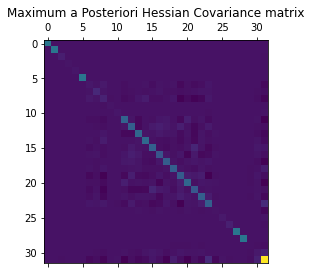

In [8]:
cov = sampler.u @ np.diag(1 / sampler.m) @ sampler.u.T

plt.matshow(cov)
plt.title('Maximum a Posteriori Hessian Covariance matrix')
plt.show()

The above Hessian covariance calculation resampled the initial point to a random draw from the covariance matrix.

In [9]:
sampler.x0

tensor([-0.0051,  0.0332,  0.0505,  0.1061,  0.0785, -0.0244,  0.0728, -0.2767,
         0.2406, -0.3710,  0.5370,  0.0587,  0.7870,  0.5335, -0.9287, -1.4863,
        -0.9685,  0.3960, -0.1055, -0.6672, -0.3665, -0.5956,  0.1077,  1.7324,
         0.0087, -0.2603, -1.3477,  0.6484, -1.2468, -0.4421, -1.1104, -0.6061])

In [10]:
chain = sampler.sample(nburn=0, burn_steps=0, burn_eps=0, nsamp=10000, samp_steps=1, samp_eps=0.05)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Here we see one sample from the chain. Note, since we passed ```transform``` to the sampler, the output of the chain is in the original parameter space.

In [11]:
chain[0]

{'x': array([ 1.0000000e-01,  4.9999999e-10,  1.0660380e+00,  3.1328592e-02,
         6.0784176e-04,  5.5000001e-01,  1.8436658e+00,  2.9936974e+00,
         2.7972939e+00,  8.9421141e-01,  2.7787435e+00,  4.1863684e-02,
         6.5875286e-03, -1.0373003e-02,  4.8641646e-03, -4.0771522e-02,
        -2.0841786e-03, -3.6611091e-02, -1.6491504e-02,  3.7746403e-02,
         2.0279510e-01,  1.1083504e-01,  1.7496713e-02, -8.4792525e-02,
        -1.0691175e+00, -4.8667059e+00,  4.9985824e+00,  1.5000000e+00,
         1.0000003e-01,  3.3407211e-02,  1.0289605e+00,  9.9954438e-01],
       dtype=float32),
 'lnP': array(-5902.9834, dtype=float32),
 'accpet_ratio': 1.0,
 'accept_prob': 1.0,
 'accepted': True}

In [12]:
print('Acceptance Rate: ', np.mean([samp['accepted'] for samp in chain]))

Acceptance Rate:  0.0358


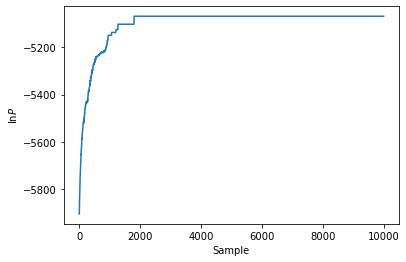

In [13]:
plt.plot([samp['lnP'] for samp in chain])
plt.xlabel('Sample')
plt.ylabel('$\\ln P$')
plt.show()

In [14]:
pickle.dump(chain, open(data_dir + 'chain.p', 'wb'))